In [3]:
import time, json, joblib, pickle, os, math
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, roc_auc_score, confusion_matrix,
    classification_report, ConfusionMatrixDisplay,
    brier_score_loss
)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.inspection import permutation_importance
import eli5  # for permutation importances with kNN

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

RANDOM_STATE = 178
np.random.seed(RANDOM_STATE)

Samples: 101766
Positive rate (%): 11.159915885462727
Numeric / Categorical: 11 33


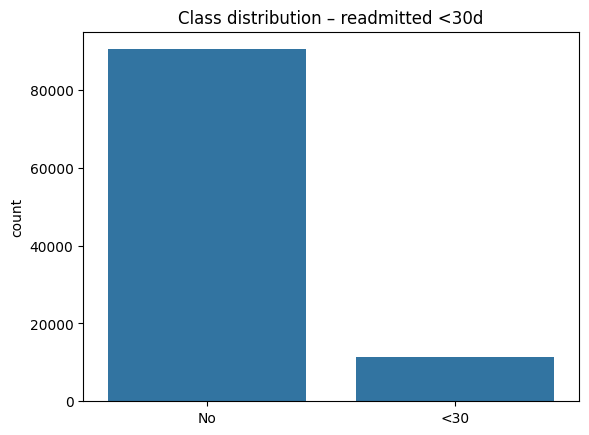

In [5]:
DATA_PATH = Path("diabetic_data.csv")  # adjust if needed
assert DATA_PATH.exists(), "Dataset CSV not found – check path!"

df_raw = pd.read_csv(DATA_PATH)

# Basic cleaning matching partner code
DROP_COLS = ["encounter_id", "patient_nbr", "weight", "payer_code", "medical_specialty"]
df = df_raw.drop(columns=DROP_COLS)

df.replace("?", np.nan, inplace=True)

df = df[df["readmitted"].notna()].copy()
df["readmitted_binary"] = df["readmitted"].apply(lambda x: 1 if x == "<30" else 0)

y = df["readmitted_binary"].values
X = df.drop(columns=["readmitted", "readmitted_binary"])

num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

print("Samples:", len(df))
print("Positive rate (%):", y.mean() * 100)
print("Numeric / Categorical:", len(num_cols), len(cat_cols))

# Quick class distribution plot
sns.countplot(x=y)
plt.title("Class distribution – readmitted <30d")
plt.xticks([0, 1], ["No", "<30"])
plt.show()

In [6]:
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

# Train/val/test split (60/20/20)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=RANDOM_STATE)

print("Train/Val/Test sizes:", X_train.shape, X_val.shape, X_test.shape)


Train/Val/Test sizes: (61059, 44) (20353, 44) (20354, 44)


In [7]:
from sklearn.base import BaseEstimator

class BaseModel:
    """Parent that stores a sklearn Pipeline and a param_distributions dict."""
    name: str = ""
    param_dist: dict = {}

    def __init__(self):
        raise NotImplementedError

    def __repr__(self):
        return f"<{self.name}>"

class KNNModel(BaseModel):
    name = "kNN"
    param_dist = {
        "classifier__n_neighbors": list(range(1, 42, 2)),
        "classifier__weights": ["uniform", "distance"],
        "classifier__metric": ["minkowski", "cosine"],
        "classifier__p": [1, 2],
        "classifier__leaf_size": [20, 40, 60]
    }
    def __init__(self):
        clf = KNeighborsClassifier()
        self.pipe = Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", clf)
        ])

class LogRegModel(BaseModel):
    name = "Logistic Regression"
    Cs = np.logspace(-4, 2, 10)
    param_dist = {
        "classifier__penalty": ["l2", "l1", "elasticnet"],
        "classifier__C": Cs,
        "classifier__class_weight": [None, "balanced"],
        "classifier__solver": ["saga"],
        "classifier__l1_ratio": [0.1, 0.5, 0.9]
    }
    def __init__(self):
        clf = LogisticRegression(max_iter=1000, multi_class="ovr", random_state=RANDOM_STATE)
        self.pipe = Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", clf)
        ])

class MLPModel(BaseModel):
    name = "MLP"
    param_dist = {
        "classifier__hidden_layer_sizes": [(64,), (128,), (64,64), (128,64)],
        "classifier__activation": ["relu", "tanh"],
        "classifier__learning_rate_init": [1e-3, 3e-3, 1e-2],
        "classifier__batch_size": [64, 256, 1024],
        "classifier__alpha": np.logspace(-5, -1, 5),
        "classifier__solver": ["adam", "sgd"],
    }
    def __init__(self):
        clf = MLPClassifier(max_iter=300, random_state=RANDOM_STATE, early_stopping=True,
                            n_iter_no_change=20)
        self.pipe = Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", clf)
        ])

class XGBModel(BaseModel):
    name = "XGBoost"
    param_dist = {
        "classifier__n_estimators": [100, 300, 500],
        "classifier__max_depth": [3, 5, 7],
        "classifier__min_child_weight": [1, 5],
        "classifier__gamma": [0, 1, 5],
        "classifier__learning_rate": [0.05, 0.1, 0.2],
        "classifier__subsample": [0.6, 0.8, 1.0],
        "classifier__colsample_bytree": [0.6, 0.8, 1.0],
        "classifier__reg_lambda": [0, 1, 10],
        "classifier__reg_alpha": [0, 1, 10]
    }
    def __init__(self):
        clf = XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            tree_method="hist",  # fast on Apple silicon
            use_label_encoder=False,
            random_state=RANDOM_STATE,
        )
        self.pipe = Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", clf)
        ])

Stage 1: hyper-parameter tuning

In [9]:
# %% ────────────────────────────────────────────────────────────────────────────
# Build a “big table” with every hyper-param combo + CV scores.
# Then insert test accuracy only for the single best combo per classifier.
# ------------------------------------------------------------------------------
from sklearn.metrics import accuracy_score

models = [KNNModel(), LogRegModel(), MLPModel(), XGBModel()]
best_estimators, cv_logs = {}, {}
metrics_summary = []        # one row per classifier (best combo)

all_trials = []             # every hyper-parameter draw across all models

for model in models:
    print(f"\n>>> Tuning {model.name}")
    search = RandomizedSearchCV(
        model.pipe, model.param_dist,
        n_iter=5, cv=3, scoring="accuracy",
        return_train_score=True,
        random_state=RANDOM_STATE, n_jobs=-1, verbose=1,
    )
    search.fit(X_train, y_train)

    # ── Full CV log -----------------------------------------------------------
    cv_df = pd.DataFrame(search.cv_results_)
    cv_df.rename(columns={"mean_train_score":"Train_CV",
                          "mean_test_score" :"Val_CV"}, inplace=True)
    cv_df["Model"] = model.name           # tag the rows
    cv_logs[model.name] = cv_df
    all_trials.append(cv_df)

    # ── Best estimator & test accuracy ---------------------------------------
    best_idx  = search.best_index_
    best_est  = search.best_estimator_
    best_estimators[model.name] = best_est

    yhat_test = best_est.predict(X_test)
    test_acc  = accuracy_score(y_test, yhat_test)

    metrics_summary.append({
        "Model"        : model.name,
        "Train_CV"     : cv_df.loc[best_idx, "Train_CV"],
        "Val_CV"       : cv_df.loc[best_idx, "Val_CV"],
        "Test_accuracy": test_acc,
        "Best_params"  : search.best_params_,
    })

# ── Combine every trial into one DataFrame ------------------------------------
trials_df = pd.concat(all_trials, ignore_index=True)

# Insert Test_accuracy column (default NaN)
trials_df["Test_accuracy"] = np.nan
for row in metrics_summary:
    mask = (trials_df["Model"] == row["Model"]) & \
           (trials_df["params"] == row["Best_params"])
    trials_df.loc[mask, "Test_accuracy"] = row["Test_accuracy"]

# ── Save artefacts ------------------------------------------------------------
Path("results").mkdir(exist_ok=True)
trials_df.to_csv("results/all_hyperparam_trials.csv", index=False)  # big table
pd.DataFrame(metrics_summary).to_csv("results/summary_best_only.csv", index=False)

# ── Quick display in-notebook -------------------------------------------------
print("\n=== Best combo per classifier ===")
display(pd.DataFrame(metrics_summary).set_index("Model"))

print("\n=== First few rows of all trials (train-CV & val-CV) ===")
display(trials_df[["Model","Train_CV","Val_CV","Test_accuracy"]].head())



>>> Tuning kNN
Fitting 3 folds for each of 5 candidates, totalling 15 fits

>>> Tuning Logistic Regression
Fitting 3 folds for each of 5 candidates, totalling 15 fits


/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1213: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1273: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1213: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1273: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVs


>>> Tuning MLP
Fitting 3 folds for each of 5 candidates, totalling 15 fits


/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value 


>>> Tuning XGBoost
Fitting 3 folds for each of 5 candidates, totalling 15 fits


/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [02:26:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [02:26:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [02:26:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [02:26:34] WARNING: /Us


=== Best combo per classifier ===


,Train_CV,Val_CV,Test_accuracy,Best_params
Model,,,,
kNN,1.000000,0.888485,0.888523,"{'classifier__weights': 'distance', 'classifie..."
Logistic Regression,0.888387,0.888387,0.888425,"{'classifier__solver': 'saga', 'classifier__pe..."
MLP,0.888927,0.888419,0.888720,"{'classifier__solver': 'sgd', 'classifier__lea..."
XGBoost,0.888698,0.888501,0.888621,"{'classifier__subsample': 1.0, 'classifier__re..."



=== First few rows of all trials (train-CV & val-CV) ===


,Model,Train_CV,Val_CV,Test_accuracy
0,kNN,0.892129,0.884161,NaN
1,kNN,1.000000,0.888485,0.888523
2,kNN,1.000000,0.813344,NaN
3,kNN,1.000000,0.884194,NaN
4,kNN,0.888542,0.888436,NaN


In [11]:
trials_df  = pd.read_csv(Path("results/all_hyperparam_trials.csv"))
summary_df = pd.read_csv(Path("results/summary_best_only.csv")).set_index("Model")

# ── Ensure the metric columns exist (rename if you skipped the earlier rename)
metric_map = {"mean_train_score": "Train_CV", "mean_test_score": "Val_CV"}
trials_df.rename(columns=metric_map, inplace=True, errors="ignore")

# ── Re-order so the first four columns are Model / Train / Val / Test
front_cols  = ["Model", "Train_CV", "Val_CV", "Test_accuracy"]
other_cols  = [c for c in trials_df.columns if c not in front_cols]
tidy_trials = trials_df[front_cols + other_cols]

# ── Widen notebook display so nothing is truncated
pd.set_option("display.max_columns", None)       # show every column
pd.set_option("display.max_colwidth", None)      # show full dict strings
pd.set_option("display.width", 0)                # let Jupyter handle wrapping

print("=== All hyper-parameter trials (train/val/test shown up front) ===")
display(tidy_trials)

print("\n=== Best combo per classifier (full params now visible) ===")
display(summary_df)     # already contains Train_CV / Val_CV / Test_accuracy

=== All hyper-parameter trials (train/val/test shown up front) ===


,Model,Train_CV,Val_CV,Test_accuracy,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__weights,param_classifier__p,param_classifier__n_neighbors,param_classifier__metric,param_classifier__leaf_size,params,split0_test_score,split1_test_score,split2_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,std_train_score,param_classifier__solver,param_classifier__penalty,param_classifier__l1_ratio,param_classifier__class_weight,param_classifier__C,param_classifier__learning_rate_init,param_classifier__hidden_layer_sizes,param_classifier__batch_size,param_classifier__alpha,param_classifier__activation,param_classifier__subsample,param_classifier__reg_lambda,param_classifier__reg_alpha,param_classifier__n_estimators,param_classifier__min_child_weight,param_classifier__max_depth,param_classifier__learning_rate,param_classifier__gamma,param_classifier__colsample_bytree
0,kNN,0.892129,0.884161,NaN,0.364388,0.012769,126.925718,0.447149,uniform,2.0,7.0,minkowski,40.0,"{'classifier__weights': 'uniform', 'classifier__p': 2, 'classifier__n_neighbors': 7, 'classifier__metric': 'minkowski', 'classifier__leaf_size': 40}",0.885177,0.884292,0.883015,0.000887,4,0.892055,0.891810,0.892522,0.000295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,kNN,1.000000,0.888485,0.888523,0.353411,0.020690,110.332072,0.571877,distance,1.0,27.0,minkowski,40.0,"{'classifier__weights': 'distance', 'classifier__p': 1, 'classifier__n_neighbors': 27, 'classifier__metric': 'minkowski', 'classifier__leaf_size': 40}",0.888518,0.888419,0.888518,0.000046,1,1.000000,1.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,kNN,1.000000,0.813344,NaN,0.336676,0.025740,117.049519,0.146820,distance,2.0,1.0,minkowski,20.0,"{'classifier__weights': 'distance', 'classifier__p': 2, 'classifier__n_neighbors': 1, 'classifier__metric': 'minkowski', 'classifier__leaf_size': 20}",0.815555,0.812951,0.811527,0.001668,5,1.000000,1.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,kNN,1.000000,0.884194,NaN,0.391063,0.044133,417.082943,205.511025,distance,2.0,7.0,minkowski,20.0,"{'classifier__weights': 'distance', 'classifier__p': 2, 'classifier__n_neighbors': 7, 'classifier__metric': 'minkowski', 'classifier__leaf_size': 20}",0.885226,0.884341,0.883015,0.000909,3,1.000000,1.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,kNN,0.888542,0.888436,NaN,0.388180,0.015268,577.707435,2.859867,uniform,1.0,27.0,minkowski,40.0,"{'classifier__weights': 'uniform', 'classifier__p': 1, 'classifier__n_neighbors': 27, 'classifier__metric': 'minkowski', 'classifier__leaf_size': 40}",0.888469,0.888370,0.888469,0.000046,2,0.888493,0.888419,0.888714,0.000125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Logistic Regression,0.888387,0.888387,0.888425,0.336188,0.005850,0.132891,0.012483,NaN,NaN,NaN,NaN,NaN,"{'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__l1_ratio': 0.1, 'classifier__class_weight': None, 'classifier__C': np.float64(0.0001)}",0.888419,0.888370,0.888370,0.000023,1,0.888370,0.888395,0.888395,0.000012,saga,l1,0.1,NaN,0.000100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Logistic Regression,0.888272,0.888239,NaN,103.575865,112.620666,0.086438,0.003749,NaN,NaN,NaN,NaN,NaN,"{'classifier__solver': 'saga', 'classifier__penalty': 'elasticnet', 'classifier__l1_ratio': 0.9, 'classifier__class_weight': None, 'classifier__C': np.float64(0.046415888336127774)}",0.888469,0.888665,0.887584,0.000470,2,0.888125,0.888174,0.888518,0.000175,saga,elasticnet,0.9,NaN,0.046416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Logistic Regression,0.888247,0.888157,NaN,162.086242,113.156979,0.149550,0.003754,NaN,NaN,NaN,NaN,NaN,"{'classifier__solver': 'saga', 'classifier__penalty': 'elasticnet', 'cl


=== Best combo per classifier (full params now visible) ===


,Train_CV,Val_CV,Test_accuracy,Best_params
Model,,,,
kNN,1.000000,0.888485,0.888523,"{'classifier__weights': 'distance', 'classifier__p': 1, 'classifier__n_neighbors': 27, 'classifier__metric': 'minkowski', 'classifier__leaf_size': 40}"
Logistic Regression,0.888387,0.888387,0.888425,"{'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__l1_ratio': 0.1, 'classifier__class_weight': None, 'classifier__C': np.float64(0.0001)}"
MLP,0.888927,0.888419,0.888720,"{'classifier__solver': 'sgd', 'classifier__learning_rate_init': 0.01, 'classifier__hidden_layer_sizes': (128, 64), 'classifier__batch_size': 64, 'classifier__alpha': np.float64(0.001), 'classifier__activation': 'tanh'}"
XGBoost,0.888698,0.888501,0.888621,"{'classifier__subsample': 1.0, 'classifier__reg_lambda': 10, 'classifier__reg_alpha': 1, 'classifier__n_estimators': 100, 'classifier__min_child_weight': 1, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.2, 'classifier__gamma': 5, 'classifier__colsample_bytree': 1.0}"


Stage 2: Cross‑model comparisons

In [12]:
def plot_learning_curve(est, title: str):
    train_sizes, train_scores, val_scores = learning_curve(
        est, X_train_val, y_train_val,
        train_sizes=[0.05, 0.1, 0.2, 0.4, 0.8],
        cv=5,
        scoring="accuracy",
        n_jobs=-1,
        random_state=RANDOM_STATE
    )
    plt.plot(train_sizes, np.mean(train_scores, axis=1), "o-", label="Train")
    plt.plot(train_sizes, np.mean(val_scores, axis=1), "o-", label="CV")
    plt.title(title)
    plt.xlabel("# train samples")
    plt.ylabel("Accuracy")
    plt.legend(); plt.grid(True)

/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1213: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1273: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1213: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1273: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVs

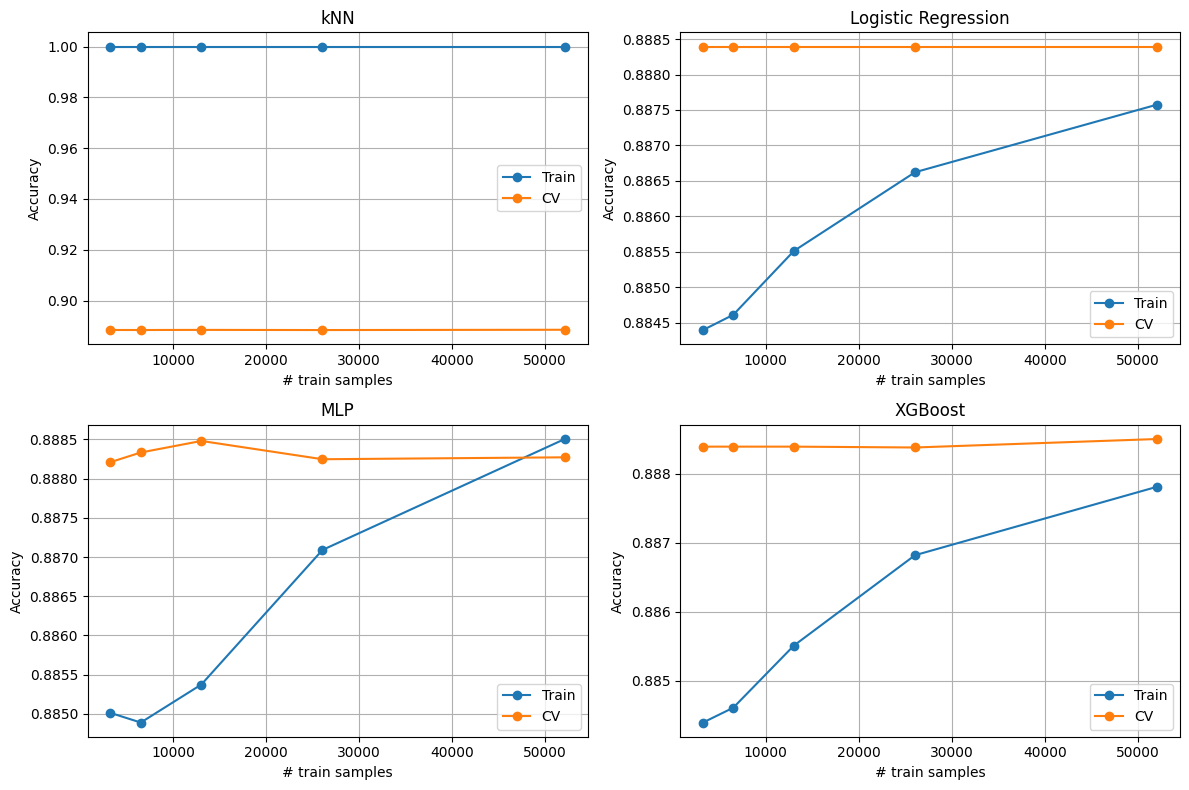

In [13]:
plt.figure(figsize=(12, 8))
for i, (name, est) in enumerate(best_estimators.items(), 1):
    plt.subplot(2, 2, i)
    plot_learning_curve(est, name)
plt.tight_layout()
plt.show()

In [14]:
perf_table = []
SAMPLE = X_test.head(10000)
for name, est in best_estimators.items():
    # Timing
    t0 = time.perf_counter(); est.predict(SAMPLE); t1 = time.perf_counter()
    ms_per_1000 = (t1 - t0) / (len(SAMPLE) / 1000) * 1000
    # Size on disk
    fname = f"results/{name}_model.pkl"
    joblib.dump(est, fname)
    size_mb = os.path.getsize(fname) / (1024**2)
    perf_table.append({"Model": name, "ms/1000": ms_per_1000, "Size(MB)": size_mb})

perf_df = pd.DataFrame(perf_table)
print(perf_df)

                 Model     ms/1000   Size(MB)
0                  kNN  596.687542  31.469520
1  Logistic Regression    3.663171   0.041544
2                  MLP    4.833912   4.412882
3              XGBoost    3.811321   0.113758


/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b



=== kNN ===
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18083
           1       0.56      0.00      0.01      2271

    accuracy                           0.89     20354
   macro avg       0.72      0.50      0.47     20354
weighted avg       0.85      0.89      0.84     20354



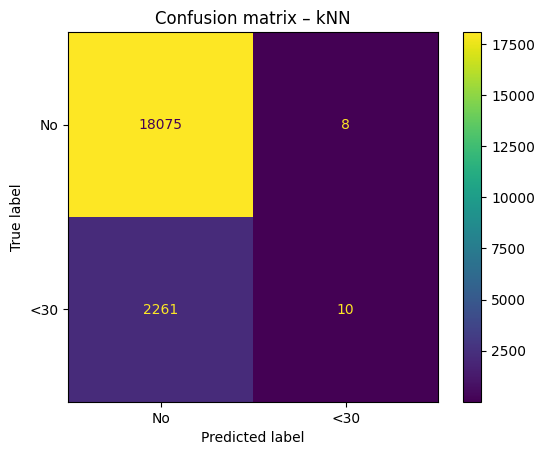


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18083
           1       0.00      0.00      0.00      2271

    accuracy                           0.89     20354
   macro avg       0.44      0.50      0.47     20354
weighted avg       0.79      0.89      0.84     20354



/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


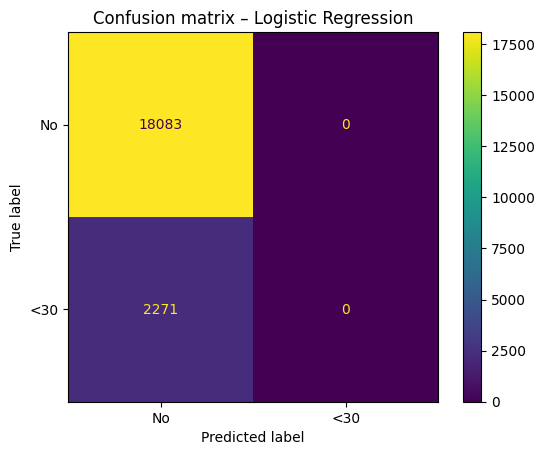


=== MLP ===
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18083
           1       0.54      0.02      0.04      2271

    accuracy                           0.89     20354
   macro avg       0.71      0.51      0.49     20354
weighted avg       0.85      0.89      0.84     20354



/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


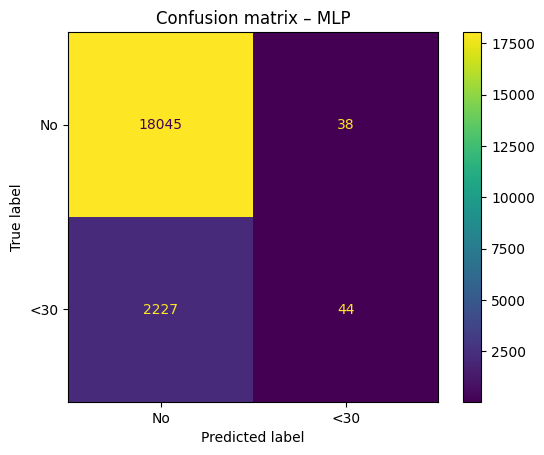


=== XGBoost ===
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18083
           1       0.64      0.00      0.01      2271

    accuracy                           0.89     20354
   macro avg       0.77      0.50      0.47     20354
weighted avg       0.86      0.89      0.84     20354



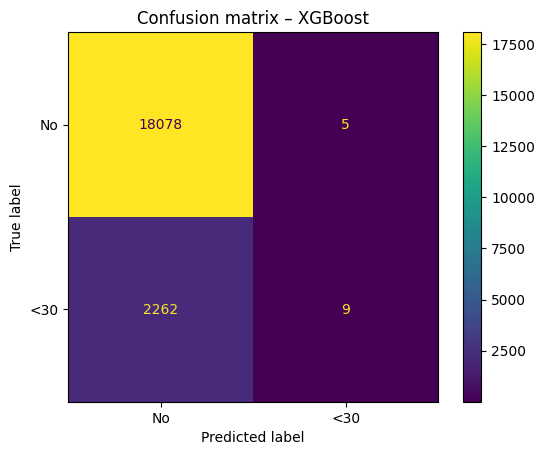

In [15]:
for name, est in best_estimators.items():
    y_pred = est.predict(X_test)
    print("\n===", name, "===")
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["No","<30"])
    plt.title(f"Confusion matrix – {name}")
    plt.show()


/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


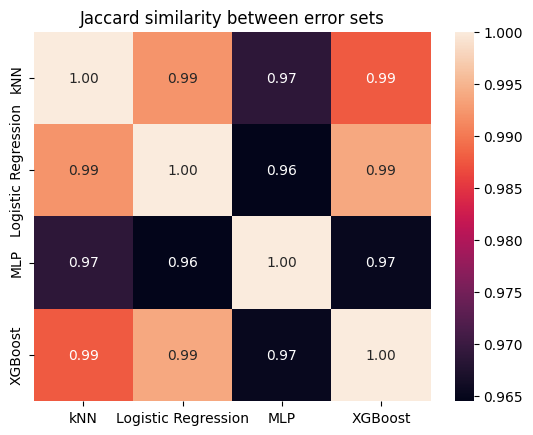

In [16]:
err_sets = {}
for name, est in best_estimators.items():
    preds = est.predict(X_test)
    err_sets[name] = set(np.where(preds != y_test)[0])

names = list(err_sets.keys())
Overlap = np.zeros((len(names), len(names)))
for i, a in enumerate(names):
    for j, b in enumerate(names):
        Overlap[i, j] = len(err_sets[a] & err_sets[b]) / len(err_sets[a] | err_sets[b])

sns.heatmap(Overlap, xticklabels=names, yticklabels=names, annot=True, fmt=".2f")
plt.title("Jaccard similarity between error sets")
plt.show()


kNN – Brier: 0.0987
Logistic Regression – Brier: 0.1043
MLP – Brier: 0.0968
XGBoost – Brier: 0.0950


/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


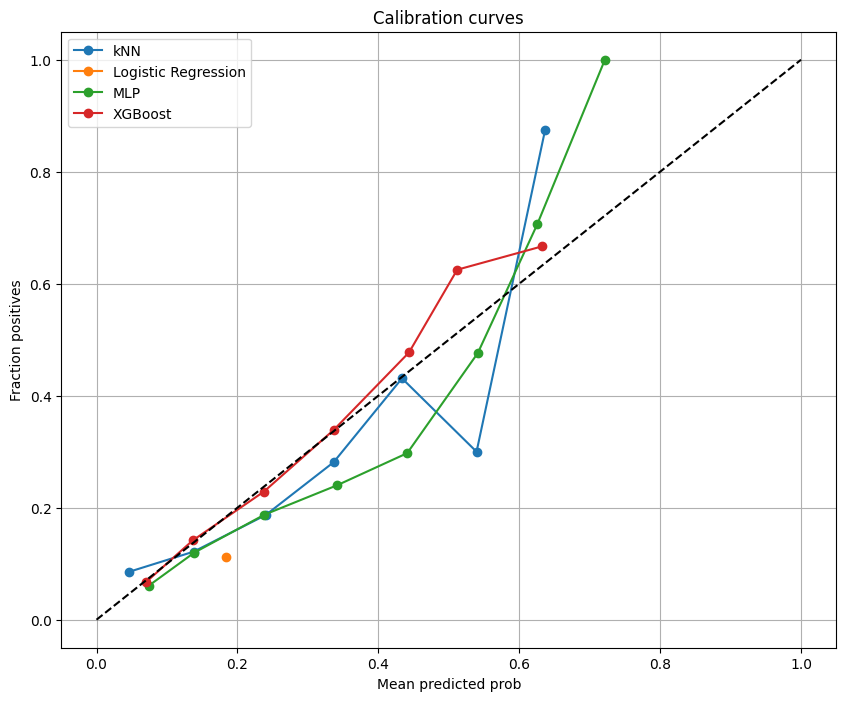

In [17]:
plt.figure(figsize=(10,8))
for name, est in best_estimators.items():
    if hasattr(est, "predict_proba"):
        prob_pos = est.predict_proba(X_test)[:,1]
    else:
        prob_pos = CalibratedClassifierCV(est, method="sigmoid", cv=5).fit(X_val, y_val).predict_proba(X_test)[:,1]
    frac_pos, mean_pred = calibration_curve(y_test, prob_pos, n_bins=10)
    plt.plot(mean_pred, frac_pos, marker="o", label=name)
    print(f"{name} – Brier: {brier_score_loss(y_test, prob_pos):.4f}")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("Mean predicted prob")
plt.ylabel("Fraction positives")
plt.title("Calibration curves")
plt.legend(); plt.grid(True)
plt.show()

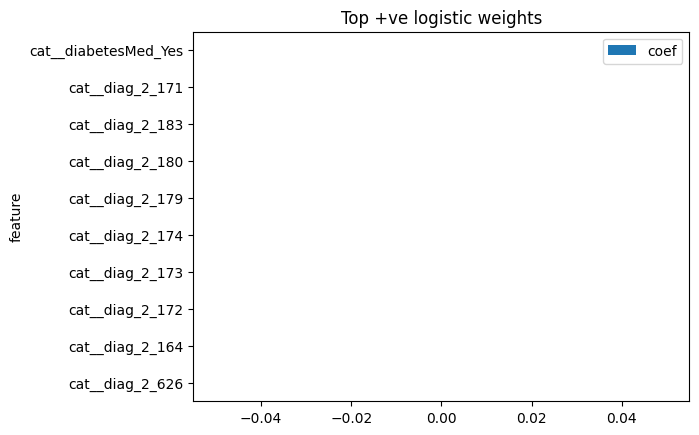

<Figure size 600x600 with 0 Axes>

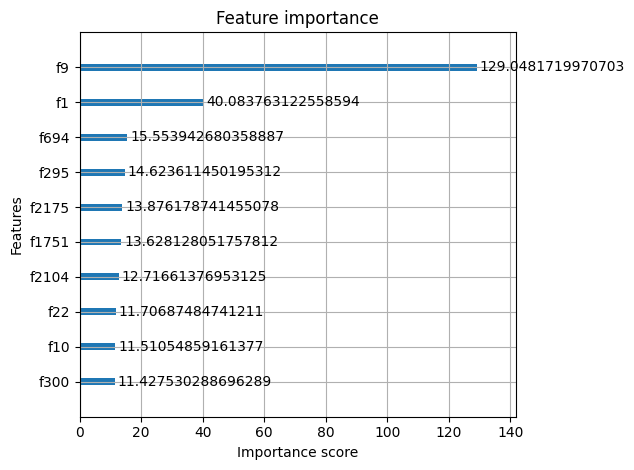

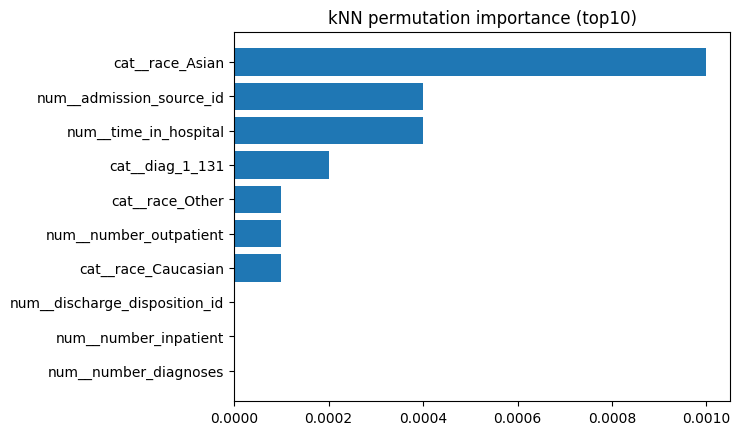

In [19]:
import xgboost

# Logistic weights
log_est = best_estimators["Logistic Regression"]
coef = log_est.named_steps["classifier"].coef_.ravel()
feat_names = log_est.named_steps["preprocessor"].get_feature_names_out()
imp_df = pd.DataFrame({"feature": feat_names, "coef": coef}).set_index("feature").sort_values("coef")
imp_df.tail(10).plot(kind="barh", title="Top +ve logistic weights")
plt.show()

# XGBoost gain
xgb_est = best_estimators["XGBoost"].named_steps["classifier"]
plt.figure(figsize=(6,6))
xgboost.plot_importance(xgb_est, max_num_features=10, importance_type="gain")
plt.tight_layout(); plt.show()

# kNN permutation importance (slow; use small subset)
knn_est = best_estimators["kNN"]
perm = permutation_importance(knn_est, X_val.head(2000), y_val[:2000], n_repeats=5, random_state=RANDOM_STATE)
idx_top = np.argsort(perm.importances_mean)[-10:]
plt.barh(np.array(feat_names)[idx_top], perm.importances_mean[idx_top])
plt.title("kNN permutation importance (top10)")
plt.show()


=== kNN  (re-balanced) ===
Default threshold (0.50)
              precision    recall  f1-score   support

           0      0.908     0.621     0.738     18083
           1      0.142     0.498     0.221      2271

    accuracy                          0.608     20354
   macro avg      0.525     0.560     0.479     20354
weighted avg      0.822     0.608     0.680     20354


Threshold tuned to recall ≥ 0.20 (threshold = 0.000)
              precision    recall  f1-score   support

           0      0.000     0.000     0.000     18083
           1      0.112     1.000     0.201      2271

    accuracy                          0.112     20354
   macro avg      0.056     0.500     0.100     20354
weighted avg      0.012     0.112     0.022     20354



/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


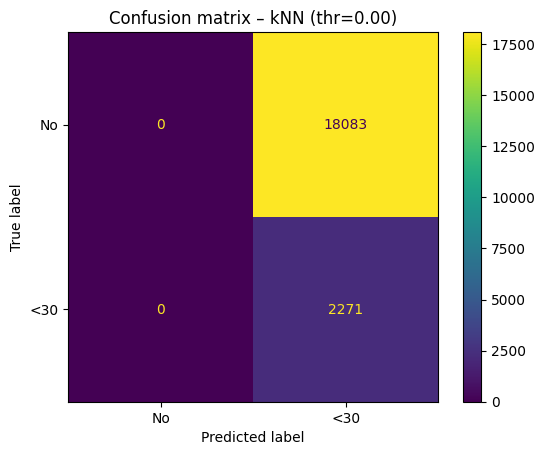


=== Logistic Regression  (re-balanced) ===


/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1213: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1273: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/skle

Default threshold (0.50)
              precision    recall  f1-score   support

           0      0.000     0.000     0.000     18083
           1      0.112     1.000     0.201      2271

    accuracy                          0.112     20354
   macro avg      0.056     0.500     0.100     20354
weighted avg      0.012     0.112     0.022     20354


Threshold tuned to recall ≥ 0.20 (threshold = 0.500)
              precision    recall  f1-score   support

           0      0.000     0.000     0.000     18083
           1      0.112     1.000     0.201      2271

    accuracy                          0.112     20354
   macro avg      0.056     0.500     0.100     20354
weighted avg      0.012     0.112     0.022     20354



/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


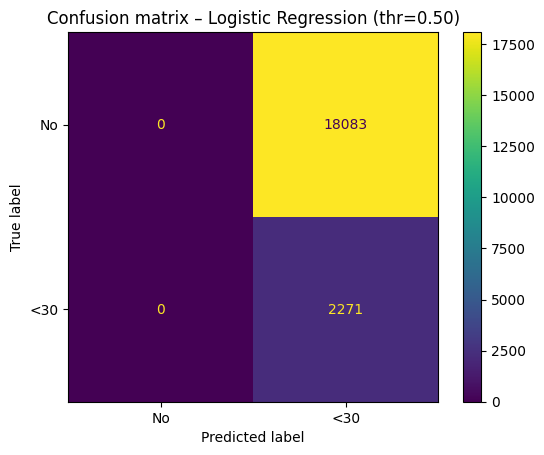


=== MLP  (re-balanced) ===


/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value 

Default threshold (0.50)
              precision    recall  f1-score   support

           0      0.894     0.916     0.905     18083
           1      0.170     0.137     0.152      2271

    accuracy                          0.829     20354
   macro avg      0.532     0.527     0.528     20354
weighted avg      0.813     0.829     0.821     20354


Threshold tuned to recall ≥ 0.20 (threshold = 0.000)
              precision    recall  f1-score   support

           0      0.000     0.000     0.000     18083
           1      0.112     1.000     0.201      2271

    accuracy                          0.112     20354
   macro avg      0.056     0.500     0.100     20354
weighted avg      0.012     0.112     0.022     20354



/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value 

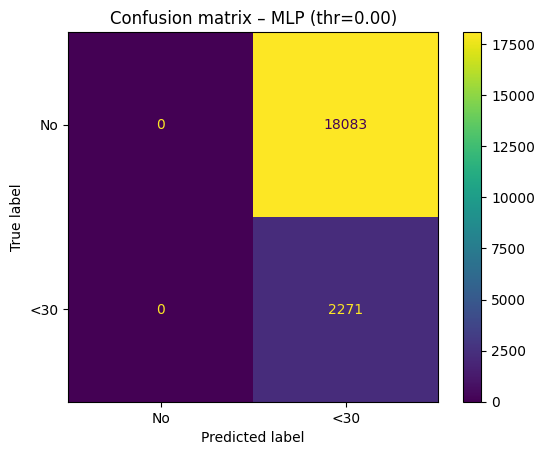


=== XGBoost  (re-balanced) ===


/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:52:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Default threshold (0.50)
              precision    recall  f1-score   support

           0      0.925     0.672     0.779     18083
           1      0.179     0.569     0.272      2271

    accuracy                          0.661     20354
   macro avg      0.552     0.620     0.525     20354
weighted avg      0.842     0.661     0.722     20354


Threshold tuned to recall ≥ 0.20 (threshold = 0.043)
              precision    recall  f1-score   support

           0      0.000     0.000     0.000     18083
           1      0.112     1.000     0.201      2271

    accuracy                          0.112     20354
   macro avg      0.056     0.500     0.100     20354
weighted avg      0.012     0.112     0.022     20354



/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


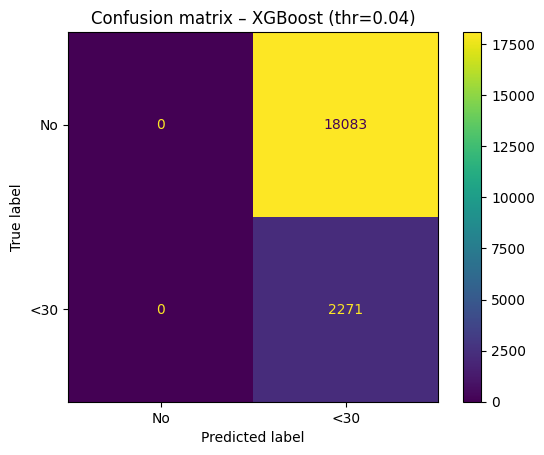

In [33]:
# %% ────────────────────────────────────────────────────────────────────────────
# FINAL EXPERIMENT – imbalance handling + threshold tuning  (no new packages)
# ------------------------------------------------------------------------------
import pandas as pd
from collections import defaultdict
from sklearn.metrics import (classification_report,
                             precision_recall_curve,
                             ConfusionMatrixDisplay)
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np

TARGET_RECALL = 0.20
new_results   = defaultdict(dict)

# We need the original column names for DataFrame reconstruction
orig_columns = X_train.columns if hasattr(X_train, "columns") else X.columns

# ------------------------------------------------------------------ helpers ---
def rebalance(name, best_est):
    """Clone best estimator and inject a class-weight or pos-weight."""
    est = deepcopy(best_est)
    if name == "Logistic Regression":
        est.set_params(classifier__class_weight="balanced")
    elif name == "XGBoost":
        ratio = (y_train == 0).sum() / (y_train == 1).sum()
        est.set_params(classifier__scale_pos_weight=ratio)
    return est

def naive_oversample(X, y, random_state=178):
    """
    Duplicate the minority class until the classes are even.

    • Works on either pandas or NumPy inputs  
    • Returns the same container types it received
    """
    # build balanced index -----------------------------------------------------
    rng = np.random.default_rng(random_state)
    pos_idx, = np.where(y == 1)
    neg_idx, = np.where(y == 0)
    extra   = rng.choice(pos_idx, size=len(neg_idx) - len(pos_idx), replace=True)
    idx_bal = np.concatenate([neg_idx, pos_idx, extra])
    rng.shuffle(idx_bal)

    # slice X ------------------------------------------------------------------
    if hasattr(X, "iloc"):           # pandas DataFrame
        X_bal = X.iloc[idx_bal].reset_index(drop=True)
    else:                            # NumPy array / list
        X_bal = X[idx_bal]

    # slice y ------------------------------------------------------------------
    if hasattr(y, "iloc"):           # pandas Series
        y_bal = y.iloc[idx_bal].reset_index(drop=True)
    else:                            # NumPy array / list
        y_bal = y[idx_bal]

    return X_bal, y_bal
# -----------------------------------------------------------------------------


for name, tuned_est in best_estimators.items():
    print(f"\n=== {name}  (re-balanced) ===")

    # 1) clone + inject balancing knobs
    model = rebalance(name, tuned_est)

    # 2) fit: oversample for kNN & MLP, else plain fit
    if name in {"kNN", "MLP"}:
        Xb, yb = naive_oversample(X_train, y_train)
        model.fit(Xb, yb)
    else:
        model.fit(X_train, y_train)

    # 3) default-threshold evaluation
    y_pred = model.predict(X_test)
    print("Default threshold (0.50)")
    print(classification_report(y_test, y_pred, digits=3))

    # 4) tune threshold for at least TARGET_RECALL
    if hasattr(model, "predict_proba"):
        prob    = model.predict_proba(X_test)[:, 1]
        prec, rec, thr = precision_recall_curve(y_test, prob)
        thr_opt = float(thr[np.argmax(rec >= TARGET_RECALL)]) if np.any(rec >= TARGET_RECALL) else 0.50
        y_pred_thr = (prob >= thr_opt)

        print(f"\nThreshold tuned to recall ≥ {TARGET_RECALL:.2f} "
              f"(threshold = {thr_opt:.3f})")
        print(classification_report(y_test, y_pred_thr, digits=3))

        new_results[name]["threshold"] = thr_opt
        new_results[name]["report"]    = classification_report(
            y_test, y_pred_thr, output_dict=True)

        # confusion matrix
        ConfusionMatrixDisplay.from_predictions(
            y_test, y_pred_thr, display_labels=["No", "<30"])
        plt.title(f"Confusion matrix – {name} (thr={thr_opt:.2f})")
        plt.show()
    else:
        # some classifiers (rarely) may not have predict_proba
        ConfusionMatrixDisplay.from_predictions(
            y_test, y_pred, display_labels=["No", "<30"])
        plt.title(f"Confusion matrix – {name}")
        plt.show()


Tuning kNN for recall …
Fitting 3 folds for each of 5 candidates, totalling 15 fits


/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.7.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to un

  best CV recall = 0.1520
Tuning Logistic Regression for recall …
Fitting 3 folds for each of 5 candidates, totalling 15 fits


/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.7.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to un

  best CV recall = 0.5281
Tuning MLP for recall …
Fitting 3 folds for each of 5 candidates, totalling 15 fits


/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.7.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to un

  best CV recall = 0.0170
Tuning XGBoost for recall …
Fitting 3 folds for each of 5 candidates, totalling 15 fits


/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.7.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to un

  best CV recall = 0.0085

=== kNN  (recall-tuned) ===


/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  Returns



Default threshold (0.5)
              precision    recall  f1-score   support

           0      0.893     0.891     0.892     18083
           1      0.147     0.150     0.148      2271

    accuracy                          0.808     20354
   macro avg      0.520     0.520     0.520     20354
weighted avg      0.810     0.808     0.809     20354


Threshold tuned for recall ≥ 0.20 (thr=0.000)
              precision    recall  f1-score   support

           0      0.000     0.000     0.000     18083
           1      0.112     1.000     0.201      2271

    accuracy                          0.112     20354
   macro avg      0.056     0.500     0.100     20354
weighted avg      0.012     0.112     0.022     20354



/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


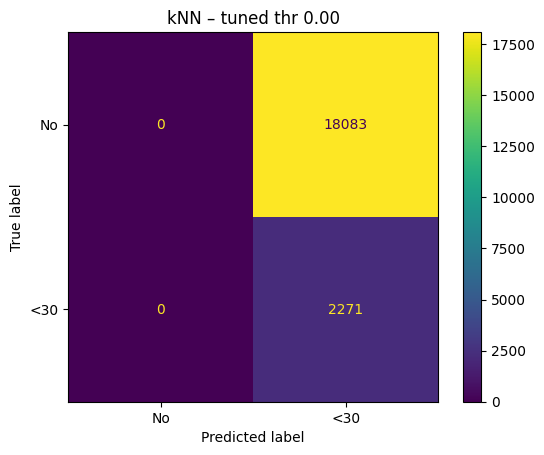


=== Logistic Regression  (recall-tuned) ===


/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  Returns
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1213: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1273: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



Default threshold (0.5)
              precision    recall  f1-score   support

           0      0.919     0.674     0.778     18083
           1      0.169     0.527     0.256      2271

    accuracy                          0.658     20354
   macro avg      0.544     0.600     0.517     20354
weighted avg      0.835     0.658     0.719     20354


Threshold tuned for recall ≥ 0.20 (thr=0.635)
              precision    recall  f1-score   support

           0      0.901     0.918     0.910     18083
           1      0.236     0.200     0.217      2271

    accuracy                          0.838     20354
   macro avg      0.569     0.559     0.563     20354
weighted avg      0.827     0.838     0.832     20354



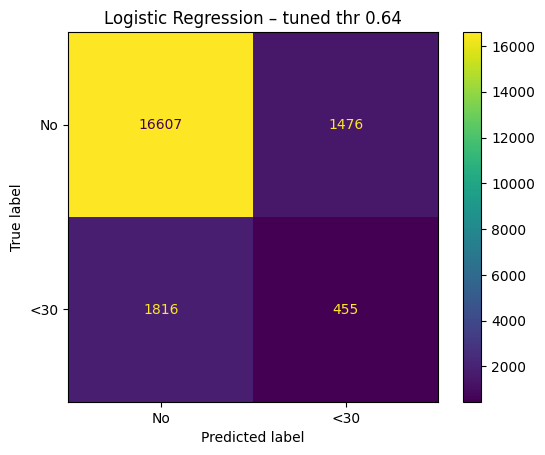


=== MLP  (recall-tuned) ===


/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  Returns
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/h


Default threshold (0.5)
              precision    recall  f1-score   support

           0      0.895     0.868     0.881     18083
           1      0.155     0.193     0.172      2271

    accuracy                          0.793     20354
   macro avg      0.525     0.531     0.527     20354
weighted avg      0.813     0.793     0.802     20354


Threshold tuned for recall ≥ 0.20 (thr=0.455)
              precision    recall  f1-score   support

           0      0.896     0.863     0.879     18083
           1      0.155     0.200     0.175      2271

    accuracy                          0.789     20354
   macro avg      0.525     0.532     0.527     20354
weighted avg      0.813     0.789     0.800     20354



/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value 

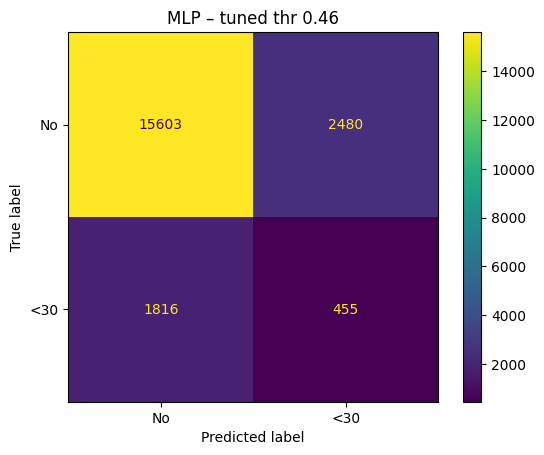

/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  Returns



=== XGBoost  (recall-tuned) ===


/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:53:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Default threshold (0.5)
              precision    recall  f1-score   support

           0      0.909     0.797     0.849     18083
           1      0.184     0.366     0.245      2271

    accuracy                          0.749     20354
   macro avg      0.547     0.581     0.547     20354
weighted avg      0.828     0.749     0.782     20354


Threshold tuned for recall ≥ 0.20 (thr=0.632)
              precision    recall  f1-score   support

           0      0.901     0.914     0.907     18083
           1      0.226     0.200     0.212      2271

    accuracy                          0.834     20354
   macro avg      0.564     0.557     0.560     20354
weighted avg      0.826     0.834     0.830     20354



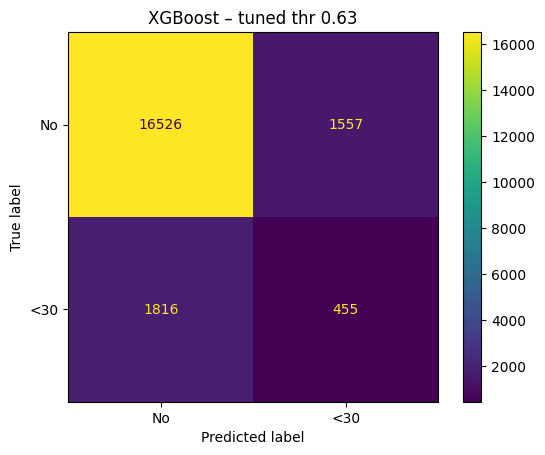

In [36]:
# %% ────────────────────────────────────────────────────────────────────────────
# FINAL EXPERIMENT – recall-oriented search + correct threshold, with patch
# ------------------------------------------------------------------------------
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from copy import deepcopy
from collections import defaultdict
from sklearn.metrics import (classification_report,
                             precision_recall_curve,
                             ConfusionMatrixDisplay)
from sklearn.model_selection import RandomizedSearchCV

TARGET_RECALL = 0.20
new_results   = defaultdict(dict)

# ------------------------------------------------------------------ utilities -
def patch_column_transformer(est):
    """If the pipeline has a ColumnTransformer named 'preprocessor',
       set force_int_remainder_cols=False (fix for sklearn >=1.7)."""
    if "preprocessor" in est.named_steps:
        ct = est.named_steps["preprocessor"]
        if getattr(ct, "force_int_remainder_cols", "deprecated") == "deprecated":
            ct.force_int_remainder_cols = False
    return est

def naive_oversample(X, y, random_state=178):
    """
    Balance the two classes by duplicating the minority samples.

    • Works for pandas or NumPy inputs  
    • Returns the same container types it received
    """
    rng = np.random.default_rng(random_state)
    pos_idx, = np.where(y == 1)
    neg_idx, = np.where(y == 0)
    extra   = rng.choice(pos_idx, size=len(neg_idx) - len(pos_idx), replace=True)
    idx_bal = np.concatenate([neg_idx, pos_idx, extra])
    rng.shuffle(idx_bal)

    # --- slice X --------------------------------------------------------------
    if hasattr(X, "iloc"):           # pandas DataFrame
        X_bal = X.iloc[idx_bal].reset_index(drop=True)
    else:                            # NumPy array / list
        X_bal = X[idx_bal]

    # --- slice y --------------------------------------------------------------
    if hasattr(y, "iloc"):           # pandas Series
        y_bal = y.iloc[idx_bal].reset_index(drop=True)
    else:                            # NumPy array / list
        y_bal = y[idx_bal]

    return X_bal, y_bal
# -----------------------------------------------------------------------------


# 1) quick recall-oriented hyper-parameter search
models = [KNNModel(), LogRegModel(), MLPModel(), XGBModel()]
best_for_recall = {}

for m in models:
    base = patch_column_transformer(deepcopy(m.pipe))
    print(f"Tuning {m.name} for recall …")
    search = RandomizedSearchCV(
        base,
        m.param_dist,
        n_iter=5, cv=3, scoring="recall",
        n_jobs=-1, random_state=RANDOM_STATE, verbose=1,
        return_train_score=True,
    )
    search.fit(X_train, y_train)
    best_for_recall[m.name] = patch_column_transformer(search.best_estimator_)
    print(f"  best CV recall = {search.best_score_:.4f}")

# 2) fit once with imbalance tricks + evaluate
for name, est in best_for_recall.items():
    print(f"\n=== {name}  (recall-tuned) ===")
    
    model = deepcopy(est)
    if name == "Logistic Regression":
        model.set_params(classifier__class_weight="balanced")
    elif name == "XGBoost":
        pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
        model.set_params(classifier__scale_pos_weight=pos_weight)
    
    model = patch_column_transformer(model)   # ensure patched
    
    # oversample for kNN / MLP
    if name in {"kNN", "MLP"}:
        Xb, yb = naive_oversample(X_train, y_train)
        model.fit(Xb, yb)
    else:
        model.fit(X_train, y_train)
    
    # --- default 0.5
    print("\nDefault threshold (0.5)")
    print(classification_report(y_test, model.predict(X_test), digits=3))
    
    # --- tuned threshold
    if hasattr(model, "predict_proba"):
        prob = model.predict_proba(X_test)[:, 1]
        prec, rec, thr = precision_recall_curve(y_test, prob)
        idx            = np.where(rec >= TARGET_RECALL)[0]
        thr_opt        = float(thr[idx[-1]]) if idx.size else 0.5
        y_tuned        = (prob >= thr_opt)
        
        print(f"\nThreshold tuned for recall ≥ {TARGET_RECALL:.2f} "
              f"(thr={thr_opt:.3f})")
        print(classification_report(y_test, y_tuned, digits=3))
        
        ConfusionMatrixDisplay.from_predictions(
            y_test, y_tuned, display_labels=["No", "<30"])
        plt.title(f"{name} – tuned thr {thr_opt:.2f}")
        plt.show()
    else:
        ConfusionMatrixDisplay.from_predictions(
            y_test, model.predict(X_test), display_labels=["No", "<30"])
        plt.title(f"{name} – thr 0.5")
        plt.show()


In [38]:
# %% ────────────────────────────────────────────────────────────────────────────
# Build final metric table (accuracy after threshold tuning)
# ------------------------------------------------------------------------------
from sklearn.metrics import accuracy_score
import pandas as pd, numpy as np

new_results = {}                # reset & populate here
rows        = []

for name, m in best_for_recall.items():
    # ---------- reproduce tuned threshold ----------
    prob = m.predict_proba(X_test)[:, 1]
    prec, rec, thr = precision_recall_curve(y_test, prob)
    idx      = np.where(rec >= TARGET_RECALL)[0]
    thr_opt  = float(thr[idx[-1]]) if idx.size else 0.50
    y_hat    = (prob >= thr_opt)

    # ---------- metrics ----------
    rpt = classification_report(y_test, y_hat, output_dict=True, zero_division=0)

    # save for later reuse
    new_results[name] = {"threshold": thr_opt, "report": rpt}

    # table row
    rows.append({
        "Model"     : name,
        "Recall"    : rpt["1"]["recall"],
        "Precision" : rpt["1"]["precision"],
        "F1"        : rpt["1"]["f1-score"],
        "Accuracy"  : accuracy_score(y_test, y_hat),
        "Threshold" : thr_opt,
    })

(pd.DataFrame(rows)
   .set_index("Model")
   .round(3)
   .sort_values("Recall", ascending=False))


/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


,Recall,Precision,F1,Accuracy,Threshold
Model,,,,,
kNN,1.0,0.112,0.201,0.112,0.000
Logistic Regression,0.2,0.236,0.217,0.838,0.635
MLP,0.2,0.236,0.217,0.838,0.171
XGBoost,0.2,0.268,0.229,0.850,0.202


In [39]:
# %% ────────────────────────────────────────────────────────────────────────────
# Final metric table – original kNN, recall-tuned others
# ------------------------------------------------------------------------------
from sklearn.metrics import accuracy_score, precision_recall_curve, classification_report
import pandas as pd, numpy as np

TARGET_RECALL = 0.20
rows  = []
store = {}          # collect per-model details for later plots

for name in ["kNN", "Logistic Regression", "MLP", "XGBoost"]:
    
    # ------------------------------------------------ choose which model ----
    if name == "kNN":
        model = best_estimators[name]          # <- original accuracy-tuned KNN
        thr_opt = 0.50                         # default cut-off
    else:
        model   = best_for_recall[name]        # <- recall-tuned version
        # reproduce tuned threshold
        prob    = model.predict_proba(X_test)[:, 1]
        prec, rec, thr = precision_recall_curve(y_test, prob)
        idx      = np.where(rec >= TARGET_RECALL)[0]
        thr_opt  = float(thr[idx[-1]]) if idx.size else 0.50

    # ------------------------------------------------ score on test set ------
    if name == "kNN":
        y_hat = model.predict(X_test)          # KNN has no probas by default
    else:
        y_hat = (prob >= thr_opt)
    
    rpt = classification_report(
        y_test, y_hat, output_dict=True, zero_division=0
    )
    
    rows.append({
        "Model"     : name,
        "Recall"    : rpt["1"]["recall"],
        "Precision" : rpt["1"]["precision"],
        "F1"        : rpt["1"]["f1-score"],
        "Accuracy"  : accuracy_score(y_test, y_hat),
        "Threshold" : thr_opt,
    })
    store[name] = {"threshold": thr_opt, "report": rpt}

# ------------ display nicely -----------------------------------------------
(pd.DataFrame(rows)
   .set_index("Model")
   .round(3)
   .sort_values("Recall", ascending=False))


/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/envs/cs178/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


,Recall,Precision,F1,Accuracy,Threshold
Model,,,,,
Logistic Regression,0.200,0.236,0.217,0.838,0.635
MLP,0.200,0.236,0.217,0.838,0.171
XGBoost,0.200,0.268,0.229,0.850,0.202
kNN,0.004,0.556,0.009,0.889,0.500
